In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import scipy.io as sio
import time

import models
import flows

In [2]:
data = sio.loadmat("./data/data.mat")
xx = data["xx"]
yy = data["yy"]
x = data["x"]
y = data["y"]
f = data["f"]
u = data["u"]

x_test = x
y_test = y
xx_test, yy_test = np.meshgrid(x_test, y_test)
N = 5000

In [3]:
mhpinn = models.MHPINN(num_tasks=N, dim=100, eps=0.0, name="mhpinn_nv")
mhpinn.restore()

permutation = list(np.arange(51, 101, 1)) + list(np.arange(0, 51, 1))

nf = flows.MAF(
    dim=101, 
    permutation=permutation,
    hidden_layers=[100, 100],
    num_bijectors=10,
    activation=tf.nn.relu,
)
nf.restore()

#### HMC

In [4]:
data = sio.loadmat("./data/downstream_hmc.mat")
x_test = data["x_test"]
y_test = data["y_test"]
f_test = data["f_test"]
u_test = data["u_test"]
x_train = data["x_train"]
y_train = data["y_train"]
f_train = data["f_train"]
noise_scale = data["noise_scale"]

In [5]:
import neuraluq as neuq

Backend is chosen to be the default, tensorflow. You can customize the backend by change it in the 'config.json' file, which can be created or found in your current directory.


In [6]:
noise_scale

array([[0.15]])

In [7]:
class Samplable(neuq.variables._Samplable):
    
    def __init__(self, nf):
        super().__init__()
        self._num_tensors = 1
        self._initial_values = [tf.function(nf.sample)([])]
        self.log_prob_fn = tf.function(nf.log_prob)
    
    def log_prob(self, samples):
        return self.log_prob_fn(samples[0])
    

class Surrogate(neuq.surrogates.Surrogate):
    
    def __init__(self, meta_model):
        self.meta_model = meta_model
        
    def __call__(self, inputs, var_list):
        x, y = tf.split(inputs, 2, axis=-1)
        xi = tf.reshape(var_list[0], [-1, 101])
        sample_size = xi.shape[0]
        batch_size = inputs.shape[0]
        if sample_size == 1:
            # inputs is of (batch_size, dim_x), outputs is of (batch_size, dim_y)
            shared = self.meta_model.shared_nn.call(inputs) # shape of [batch_size, dim]
            out = tf.matmul(shared, tf.transpose(xi[..., :100])) + tf.transpose(xi[..., 100:])
            out = x * (1 - x) * y * (1 - y) * out
        else:
            # outputs is of (sample_size, batch_size, dim_x), so the inputs should be
            # of (sample_size, batch_size, dim_x), compared to its original shape:
            # (batch_size, dim_x)
            print(inputs.shape)
            #inputs = tf.tile(inputs[None, ...], [sample_size, 1, 1])
            shared = self.meta_model.shared_nn.call(tf.reshape(inputs, [-1, 1])) # shape in [sample_size * batch_size, dim]
            shared = tf.reshape(shared, [sample_size, batch_size, -1])
            out = tf.einsum("SBj,Sj->SB", shared, xi[..., :100]) + xi[..., 100:]
            out = x * (1 - x) * y * (1 - y) * out[..., None]
        return out
    
    
def pde_fn(inputs, u_fn):
    u = u_fn(inputs)
    u_x, u_y = tf.split(tf.gradients(u, inputs)[0], 2, axis=-1)
    u_xx = tf.gradients(u_x, inputs)[0][:, 0:1]
    u_yy = tf.gradients(u_y, inputs)[0][:, 1:2]
    f = 0.1 * (u_xx + u_yy) + u * (u**2 - 1)
    return f

In [8]:
prior = Samplable(nf)
surrogate = Surrogate(mhpinn)
process = neuq.process.Process(surrogate=surrogate, prior=prior)

likelihood = neuq.likelihoods.Normal(
    inputs=np.concatenate([x_train, y_train], axis=-1), 
    targets=f_train, 
    sigma=noise_scale, 
    processes=[process],
    equation=pde_fn,
)

model = neuq.models.Model(
    processes=[process], likelihoods=[likelihood],
)

Supporting backend tensorflow



In [9]:
method = neuq.inferences.HMC(
    num_samples=1000,
    num_burnin=1000,
    init_time_step=0.01,
    leapfrog_step=50,
    seed=6666,
)
model.compile(method)

Compiling a MCMC method



In [10]:
t0 = time.time()
samples, results = model.run()
t1 = time.time()
print("Acceptance rate: %.3f \n"%(np.mean(results)))  # if HMC is used
print("Elapsed of HMC: ", t1 - t0)

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

Acceptance rate: 0.719 

Elapsed of HMC:  453.36134457588196


In [12]:
xx, yy = np.meshgrid(x, y)
xx_test = tf.constant(xx.reshape([-1, 1]), tf.float32)
yy_test = tf.constant(yy.reshape([-1, 1]), tf.float32)

u_pred = mhpinn.call(xx_test, yy_test, tf.transpose(samples[0])).numpy()
f_pred = mhpinn.pde(xx_test, yy_test, tf.transpose(samples[0])).numpy()
u_pred = u_pred.reshape([101, 101, 1000])
f_pred = f_pred.reshape([101, 101, 1000])

u_mu = np.mean(u_pred, axis=-1)
u_sd = np.std(u_pred, axis=-1)
f_mu = np.mean(f_pred, axis=-1)
f_sd = np.std(f_pred, axis=-1)

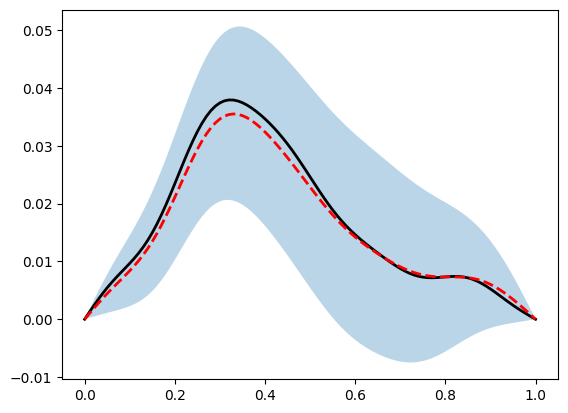

In [16]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot()
i = 32
# ax.scatter(x_train[y_train == y[0, i]], f_train[y_train == y[0, i]], s=5, color="blue", marker="o", facecolor="none", linewidths=8, label="measurements")
ax.plot(x.flatten(), u_test[i, :], color="black", linestyle="-", linewidth=2, label="reference")
ax.plot(x.flatten(), u_mu[i, :], color="red", linestyle="--", linewidth=2, label="mean")
ax.fill_between(x.flatten(), (u_mu+2*u_sd)[i, :], (u_mu-2*u_sd)[i, :], alpha=0.3, label="2 std")
# ax.legend(loc=0)
# ax.set_ylim([-0.5, 0.5])
# ax.set_xlabel("$x$")
# ax.set_ylabel("$f$")
# ax.set_title("$y=$"+str(y_test[0, i]))
# ax.set_box_aspect(2/3)
# # fig.savefig("f_0_uq.png")

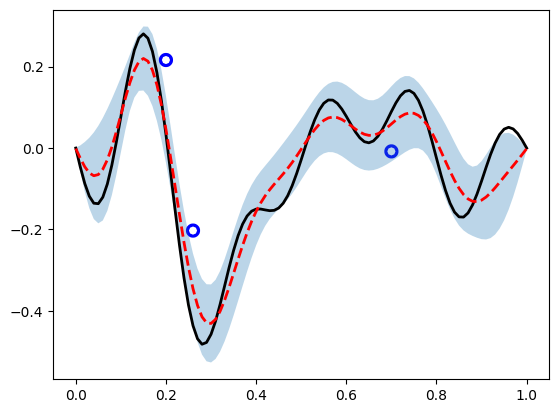

In [13]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot()
i = 32
ax.scatter(x_train[y_train == y[0, i]], f_train[y_train == y[0, i]], s=5, color="blue", marker="o", facecolor="none", linewidths=8, label="measurements")
ax.plot(x.flatten(), f_test[i, :], color="black", linestyle="-", linewidth=2, label="reference")
ax.plot(x.flatten(), f_mu[i, :], color="red", linestyle="--", linewidth=2, label="mean")
ax.fill_between(x.flatten(), (f_mu+2*f_sd)[i, :], (f_mu-2*f_sd)[i, :], alpha=0.3, label="2 std")
# ax.legend(loc=0)
# ax.set_ylim([-0.5, 0.5])
# ax.set_xlabel("$x$")
# ax.set_ylabel("$f$")
# ax.set_title("$y=$"+str(y_test[0, i]))
# ax.set_box_aspect(2/3)
# # fig.savefig("f_0_uq.png")

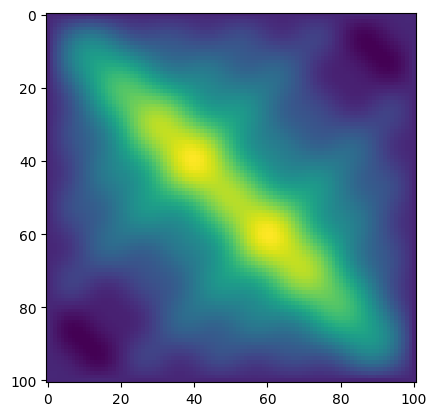

In [14]:
plt.imshow(u_test)

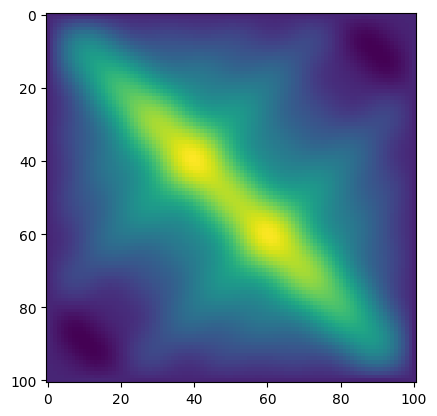

In [15]:
plt.imshow(u_mu)

In [15]:
sio.savemat(
    "./outputs/hmc.mat",
    {
        "x": x, "y": y, "f_ref": f_test, "u_ref": u_test,
        "f_mu": f_mu, "f_std": f_sd, "u_mu": u_mu, "u_std": u_sd,
        "x_train": x_train, "y_train": y_train, "f_train": f_train,
    }
)

In [18]:
x_train.shape

(100, 1)

In [19]:
noise_scale

array([[0.15]])